In [1]:
import numpy as np
import pandas as pd 
import anndata as ad
import scanpy as sc

import screenpro as scp

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=150, format='svg', frameon=False, figsize=(3, 3), color_map='RdGy', facecolor='white')

In [2]:
almost_black = '#111111'

dark2 = ['#1b9e77',
         '#d95f02',
         '#7570b3',
         '#e7298a',
         '#66a61e',
         '#e6ab02',
         '#a6761d',
         '#666666']

In [42]:
help(scp.phenoScore.getPhenotypeScore)

Help on function getPhenotypeScore in module screenpro.phenoScore:

getPhenotypeScore(x, y, x_ctrl, y_ctrl, growth_rate, math, ave)
    Calculate phenotype score normalized by negative control and growth rate.
    Args:
        x (np.array): array of values
        y (np.array): array of values
        x_ctrl (np.array): array of values
        y_ctrl (np.array): array of values
        growth_rate (int): growth rate
        math (str): math to use for calculating score
        ave (str): average method
    Returns:
        np.array: array of scores



In [40]:
def get_replicate_score(screen,x_label, y_label):
    adata_ctrl = screen.adata[:,screen.adata.var.targetType.eq('negCtrl')].copy()

    results = {}
    
    for replicate in screen.adata.obs.replicate.unique():

        res = scp.phenoScore.getPhenotypeScore(
            x = screen.adata[screen.adata.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y = screen.adata[screen.adata.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            x_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            growth_rate=1,
            math = screen.math,
            ave = 'row' # in the selected datasets, there is only one column so `row` average is the raw count.
        )
        
        results.update({f'replicate_{replicate}':res})
    
    
    out = pd.DataFrame(
        results,
        index = screen.adata.var.index
    )
    return out

In [4]:
# replicate scatter plots

def draw_scatter(adata, x, y, title, ax):
    bdata = adata[[x, y],:].copy()
    
    bdata.obs.index = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    x_lab, y_lab = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    
    sc.pp.log1p(bdata)
    sc.pl.scatter(
        bdata,
        x_lab, y_lab,
        legend_fontsize='xx-large',
        palette=[almost_black,'#BFBFBF'],
        color='targetType',
        title=title,
        size=5,
        show=False,
        ax = ax
    )
    # ax.set_ylim(-1,11)
    # ax.set_xlim(-1,11)
    ax.tick_params(axis='both', labelsize=10)
    ax.get_legend().remove()
    
    ax.grid(False)

### 

    Day	parent_vehicle	parent_DNAPKi	PRDX1ko_vehicle	PRDX1ko_DNAPKi
    0	0	0	0	0
    2	1.456360474	1.412026796	1.1919571	0.784588481
    4	3.273877431	3.292421855	2.809047771	1.20319948
    7	5.080287121	4.910093439	4.259156669	1.645972469
    9	6.364117197	6.129554774	5.63579411	1.820274401
    11	7.886372682	7.570238507	7.104481135	2.177486774

In [5]:
# meta = pd.read_excel('PRDX1ko_screengrowthsummary.xlsx',index_col=0)
# meta = pd.DataFrame(meta.reset_index()['Sample'].str.split(' |_').str[1:].to_list(),columns=['condition','replicate'],index=meta.Label.to_list())
# meta.replicate = meta.replicate.str[-1].astype(int)

In [6]:
adata = ad.read_h5ad('results/adata_counts.h5ad.gz')

del adata.layers

adata.obs.treatment = adata.obs.treatment.str.replace('-','T0')
adata.obs = adata.obs.rename(columns={'treatment':'condition','rep':'replicate'})

___
- filter low counts

In [7]:
adata = adata[:,adata.to_df().sum().gt(50)].copy()

In [8]:
# target_df
adata.var.head(3)

,target,targetType
non-targeting_00718|non-targeting_01902++non-targeting_00718|non-targeting_01902,non-targeting,negCtrl
ZDHHC13_+_19138761.23-P1P2|ZDHHC13_-_19138728.23-P1P2++ZDHHC13_+_19138761.23-P1P2|ZDHHC13_-_19138728.23-P1P2,ZDHHC13,gene
ARNTL2_+_27485837.23-P1P2|ARNTL2_+_27485847.23-P1P2++ARNTL2_+_27485837.23-P1P2|ARNTL2_+_27485847.23-P1P2,ARNTL2,gene


In [9]:
adata.obs

,cell line,timepoint,condition,replicate
index,,,,
i01,parent,T0,T0,1
i02,parent,T0,T0,2
i03,parent,Tend,vehicle,1
i04,parent,Tend,vehicle,2
i05,parent,Tend,vehicle,3
i06,parent,Tend,DNAPKi,1
i07,parent,Tend,DNAPKi,2
i08,parent,Tend,DNAPKi,3
i09,PRDX1KO,T0,T0,1


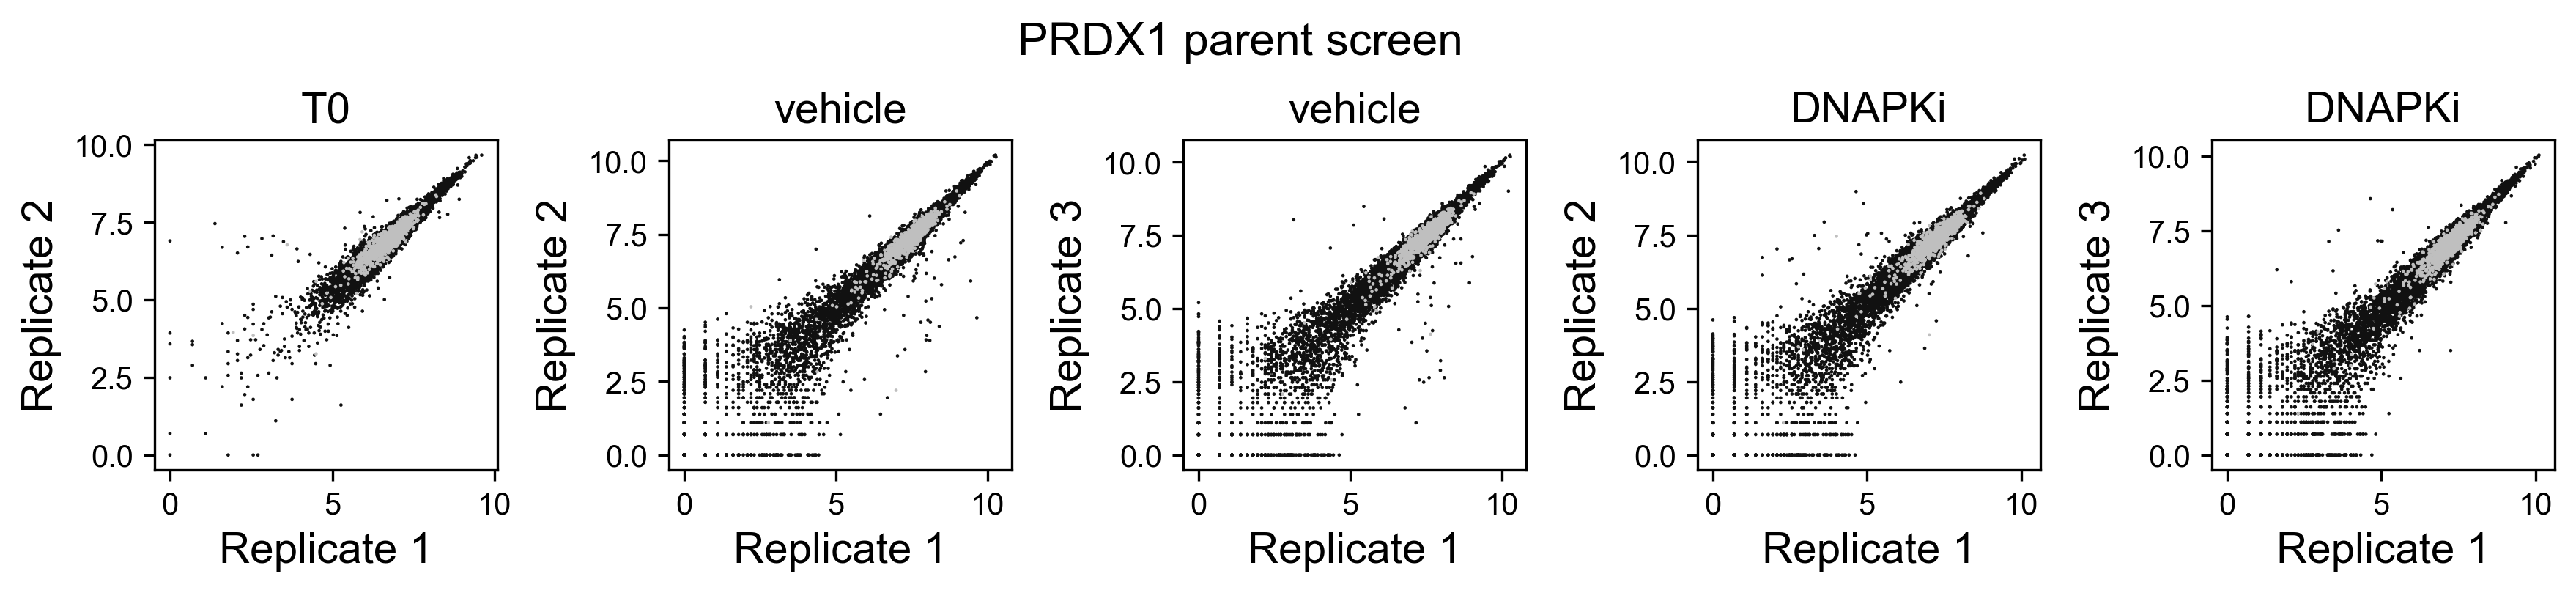

In [38]:
fig, axes = plt.subplots(ncols=5,
                         figsize=(13,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
draw_scatter(adata, 'i01','i02','T0', axes[0])
draw_scatter(adata, 'i03','i04','vehicle', axes[1])
draw_scatter(adata, 'i03','i05','vehicle', axes[2])
draw_scatter(adata, 'i06','i07','DNAPKi', axes[3])
draw_scatter(adata, 'i06','i08','DNAPKi', axes[4])

fig.suptitle('PRDX1 parent screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

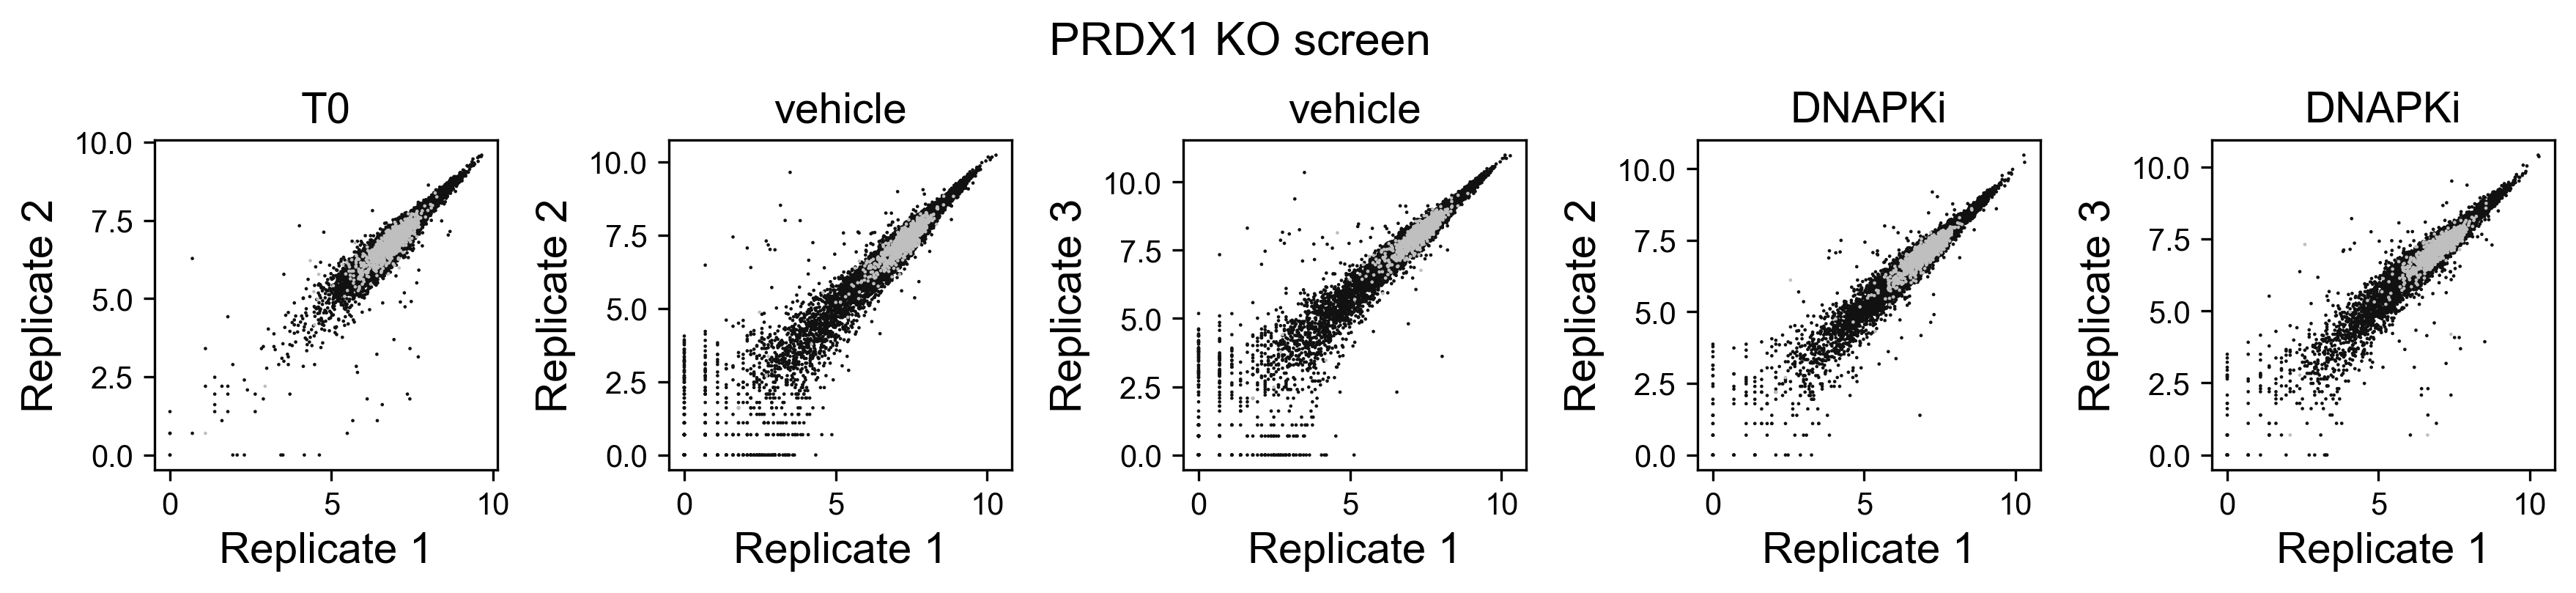

In [39]:
fig, axes = plt.subplots(ncols=5,
                         figsize=(13,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
draw_scatter(adata, 'i09','i10','T0', axes[0])
draw_scatter(adata, 'i11','i12','vehicle', axes[1])
draw_scatter(adata, 'i11','i13','vehicle', axes[2])
draw_scatter(adata, 'i14','i15','DNAPKi', axes[3])
draw_scatter(adata, 'i14','i16','DNAPKi', axes[4])

fig.suptitle('PRDX1 KO screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

### scores

    'PRDX1_parent gamma vehicle_vs_T0',
    'PRDX1_parent rho DNAPKi_vs_vehicle',
    'PRDX1_parent tau DNAPKi_vs_T0',

    'PRDX1_KO gamma vehicle_vs_T0',
    'PRDX1_KO rho DNAPKi_vs_vehicle',
    'PRDX1_KO tau DNAPKi_vs_T0',
<!--     'rho vehicle_PRDX1KO_vs_vehicle_parent' -->

___

    Day	parent_vehicle	parent_DNAPKi	PRDX1ko_vehicle	PRDX1ko_DNAPKi
    0	0	0	0	0
    2	1.456360474	1.412026796	1.1919571	0.784588481
    4	3.273877431	3.292421855	2.809047771	1.20319948
    7	5.080287121	4.910093439	4.259156669	1.645972469
    9	6.364117197	6.129554774	5.63579411	1.820274401
    11	7.886372682	7.570238507	7.104481135	2.177486774

In [10]:
adata_PRDX1KO = adata[adata.obs['cell line'].eq('PRDX1KO')].copy()
adata_parent  = adata[adata.obs['cell line'].eq('parent')].copy()

### PRDX1 parent screen

In [11]:
screen = scp.ScreenPro(adata_parent)

screen.adata.obs

,cell line,timepoint,condition,replicate
index,,,,
i01,parent,T0,T0,1
i02,parent,T0,T0,2
i03,parent,Tend,vehicle,1
i04,parent,Tend,vehicle,2
i05,parent,Tend,vehicle,3
i06,parent,Tend,DNAPKi,1
i07,parent,Tend,DNAPKi,2
i08,parent,Tend,DNAPKi,3


In [12]:
screen.n_reps = 2

In [13]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='DNAPKi',
    db_untreated = 7.8,
    db_treated = 7.5,
    score_level='compare_reps'
)

	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


In [14]:
help(scp.pl.plot_volcano)

Help on function plot_volcano in module screenpro.plotting:

plot_volcano(ax, df_in, threshold, up_hit='resistance_hit', down_hit='sensitivity_hit', xlim_l=-5, xlim_r=5, ylim=6)



In [15]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

tau = screen.phenotypes['compare_reps']['tau:DNAPKi_vs_T0'].iloc[:,:3].reset_index(drop=True)

rho = screen.phenotypes['compare_reps']['rho:DNAPKi_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

In [16]:
gamma.score.min(),gamma.score.max(), max(-np.log10(gamma['ttest pvalue']))

(-1.3166671876964988, 0.6399593555224782, 5.019365537593026)

In [17]:
tau.score.min(),tau.score.max(),max(-np.log10(tau['ttest pvalue']))

(-1.3838809348395396, 0.770770532131683, 4.898855171316234)

In [18]:
rho.score.min(),rho.score.max(),max(-np.log10(rho['ttest pvalue']))

(-16.071947885129752, 19.57566715810244, 4.031790337870748)

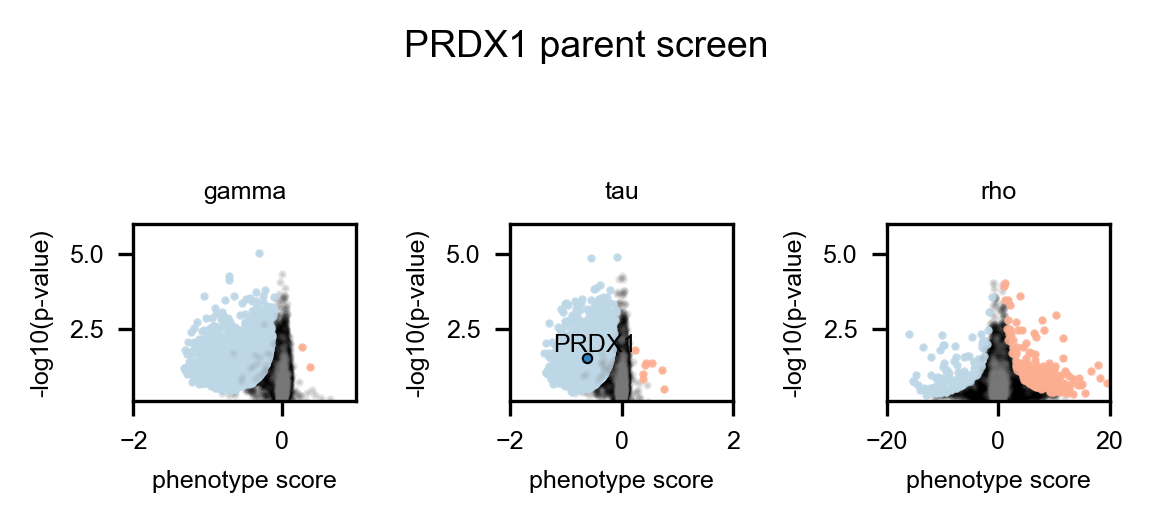

In [19]:
# Create subplots and specify the size
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(4, 1.8))

scp.pl.plot_volcano(ax1, gamma,threshold=5,xlim_l=-2, xlim_r=1)
ax1.grid(False)
ax1.get_legend().remove()
ax1.set_title('gamma')

scp.pl.plot_volcano(ax2, tau,threshold=5,xlim_l=-2, xlim_r=2)
scp.pl.label_sensitivity_hit(ax2,tau,'PRDX1',threshold=5,size=5,size_txt=6,t_x=-.6,t_y=.2)

ax2.grid(False)
ax2.get_legend().remove()
ax2.set_title('tau')

scp.pl.plot_volcano(ax3, rho,threshold=5,xlim_l=-20, xlim_r=20)
# label_resistance_hit(ax2,rho,'TTC1',size=5,size_txt=6,t_x=.1)
# label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.1)

ax3.grid(False)
ax3.get_legend().remove()
ax3.set_title('rho')


for ax in [ax1,ax2,ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

fig.suptitle('PRDX1 parent screen',fontsize=9)
plt.tight_layout()
# Show the plot
plt.show()

In [21]:
pdata = ad.AnnData(
    X=pd.concat([
        get_replicate_score(screen,'T0', 'vehicle').add_prefix('gamma_'),
        get_replicate_score(screen,'T0', 'DNAPKi').add_prefix('tau_'),
        get_replicate_score(screen,'vehicle', 'DNAPKi').add_prefix('rho_')
    ],axis=1).T,
    var=screen.adata.var
)

pdata.obs['score'] = pdata.obs.index.str.split('_').str[0]
pdata.obs['replicate'] = pdata.obs.index.str.split('_').str[2]

/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/94/b_7221fj6j380ss7gybjl7yr0000gq/T/ipykernel_21121/2476915187.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warn

/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


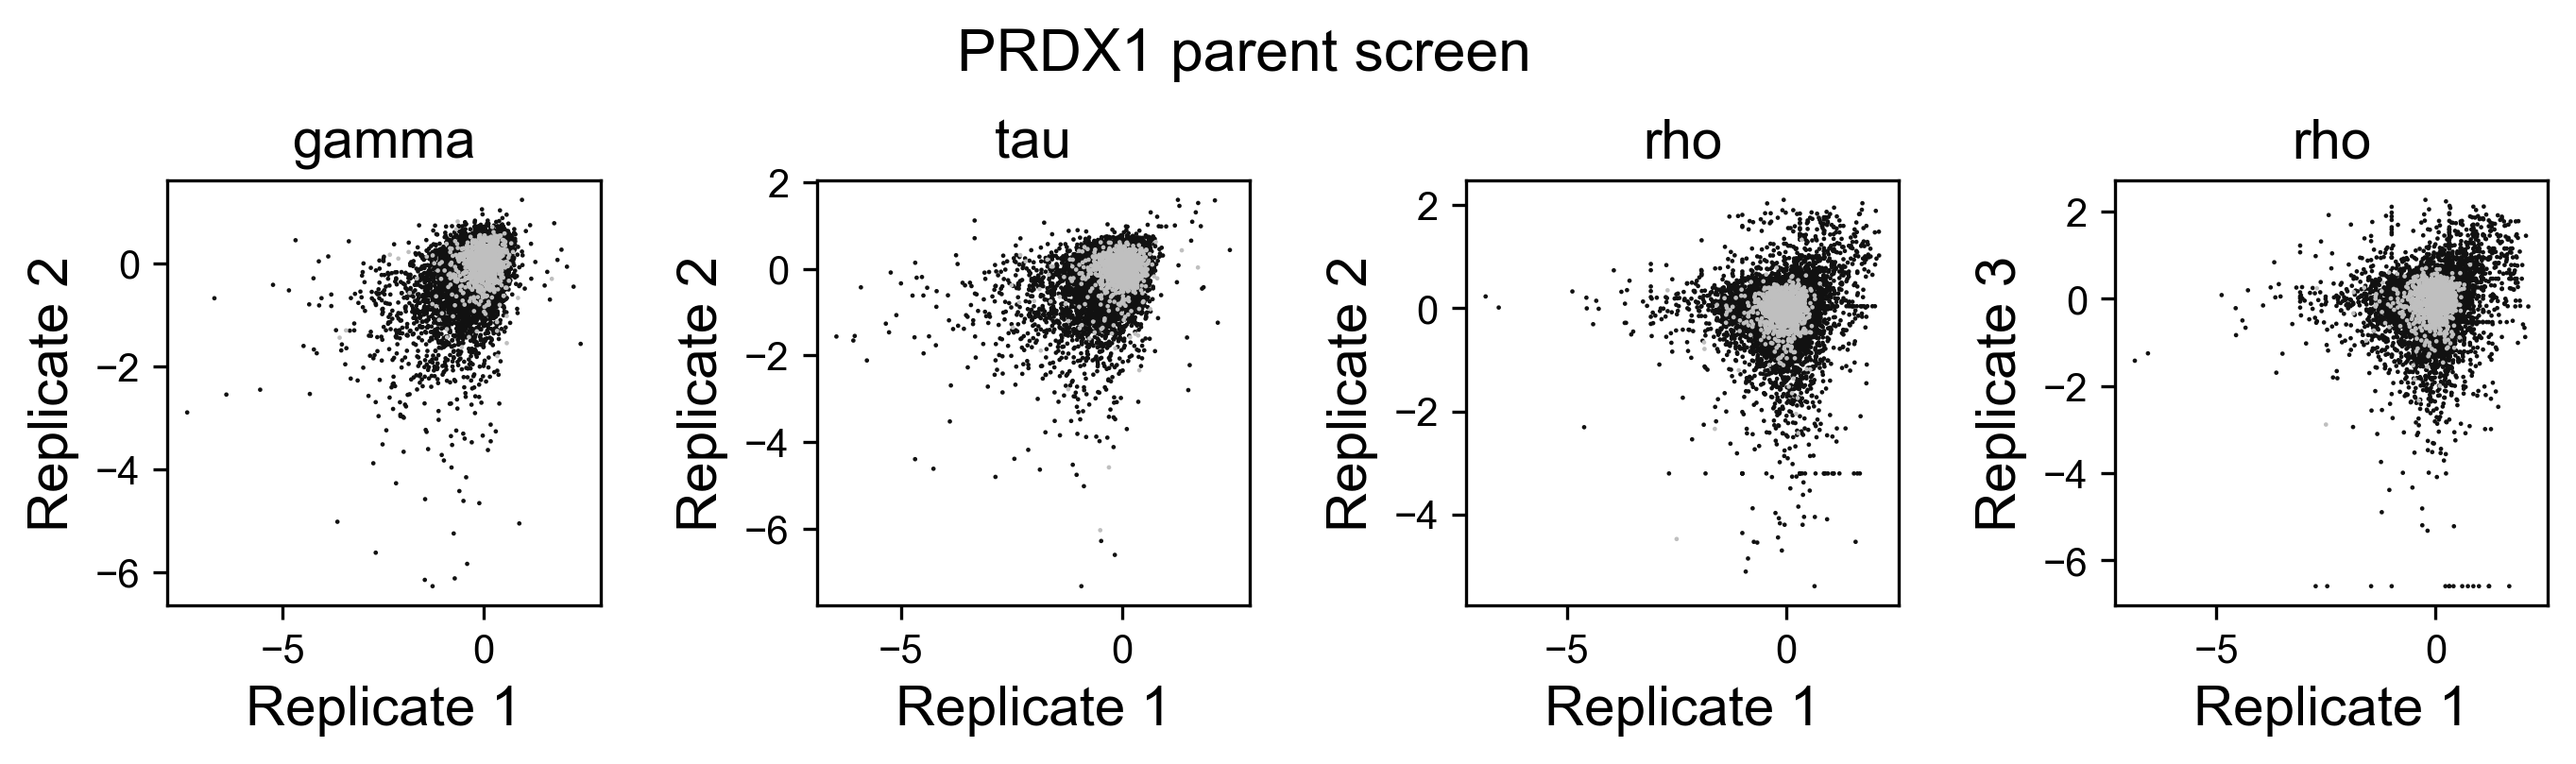

In [28]:
fig, axes = plt.subplots(ncols=4,
                         figsize=(10,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
draw_scatter(pdata, 'gamma_replicate_1','gamma_replicate_2','gamma', axes[0])
draw_scatter(pdata, 'tau_replicate_1','tau_replicate_2','tau', axes[1])

draw_scatter(pdata, 'rho_replicate_1','rho_replicate_2','rho', axes[2])
draw_scatter(pdata, 'rho_replicate_1','rho_replicate_3','rho', axes[3])

fig.suptitle('PRDX1 parent screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

### PRDX1 KO screen

In [23]:
screen = scp.ScreenPro(adata_PRDX1KO)

screen.adata.obs

,cell line,timepoint,condition,replicate
index,,,,
i09,PRDX1KO,T0,T0,1
i10,PRDX1KO,T0,T0,2
i11,PRDX1KO,Tend,vehicle,1
i12,PRDX1KO,Tend,vehicle,2
i13,PRDX1KO,Tend,vehicle,3
i14,PRDX1KO,Tend,DNAPKi,1
i15,PRDX1KO,Tend,DNAPKi,2
i16,PRDX1KO,Tend,DNAPKi,3


In [24]:
screen.n_reps = 2

In [25]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='DNAPKi',
    db_untreated = 7.1,
    db_treated = 2.1,
    score_level='compare_reps'
)

	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


In [26]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

tau = screen.phenotypes['compare_reps']['tau:DNAPKi_vs_T0'].iloc[:,:3].reset_index(drop=True)

rho = screen.phenotypes['compare_reps']['rho:DNAPKi_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

In [103]:
gamma.score.min(),gamma.score.max(), max(-np.log10(gamma['ttest pvalue']))

(-1.606974691309949, 0.6605596055865346, 5.020886675155205)

In [104]:
tau.score.min(),tau.score.max(),max(-np.log10(tau['ttest pvalue']))

(-4.4941930199187885, 2.584907126038296, 4.649575945290513)

In [105]:
rho.score.min(),rho.score.max(),max(-np.log10(rho['ttest pvalue']))

(-0.6165078075706603, 1.4355785496018683, 4.461126290697124)

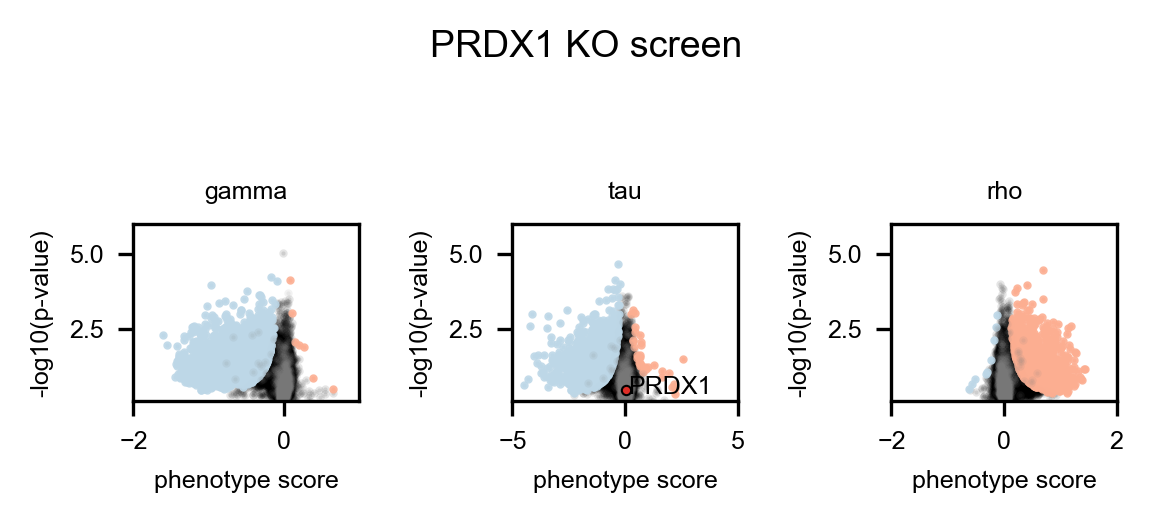

In [106]:
# Create subplots and specify the size
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(4, 1.8))

scp.pl.plot_volcano(ax1, gamma,threshold=5,xlim_l=-2, xlim_r=1)
ax1.grid(False)
ax1.get_legend().remove()
ax1.set_title('gamma')

scp.pl.plot_volcano(ax2, tau,threshold=5,xlim_l=-5, xlim_r=5)
scp.pl.label_resistance_hit(ax2,tau,'PRDX1',threshold=5,size=5,size_txt=6,t_x=.1)
# label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.1)

ax2.grid(False)
ax2.get_legend().remove()
ax2.set_title('tau')

scp.pl.plot_volcano(ax3, rho,threshold=5,xlim_l=-2, xlim_r=2)
# label_resistance_hit(ax2,rho,'TTC1',size=5,size_txt=6,t_x=.1)
# label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.1)

ax3.grid(False)
ax3.get_legend().remove()
ax3.set_title('rho')


for ax in [ax1,ax2,ax3]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

fig.suptitle('PRDX1 KO screen',fontsize=9)
plt.tight_layout()
# Show the plot
plt.show()

In [107]:
pdata = ad.AnnData(
    X=pd.concat([
        get_replicate_score(screen,'T0', 'vehicle').add_prefix('gamma_'),
        get_replicate_score(screen,'T0', 'DNAPKi').add_prefix('tau_'),
        get_replicate_score(screen,'vehicle', 'DNAPKi').add_prefix('rho_')
    ],axis=1).T,
    var=screen.adata.var
)

pdata.obs['score'] = pdata.obs.index.str.split('_').str[0]
pdata.obs['replicate'] = pdata.obs.index.str.split('_').str[2]

/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/94/b_7221fj6j380ss7gybjl7yr0000gq/T/ipykernel_15188/2476915187.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warn

/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/opt/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


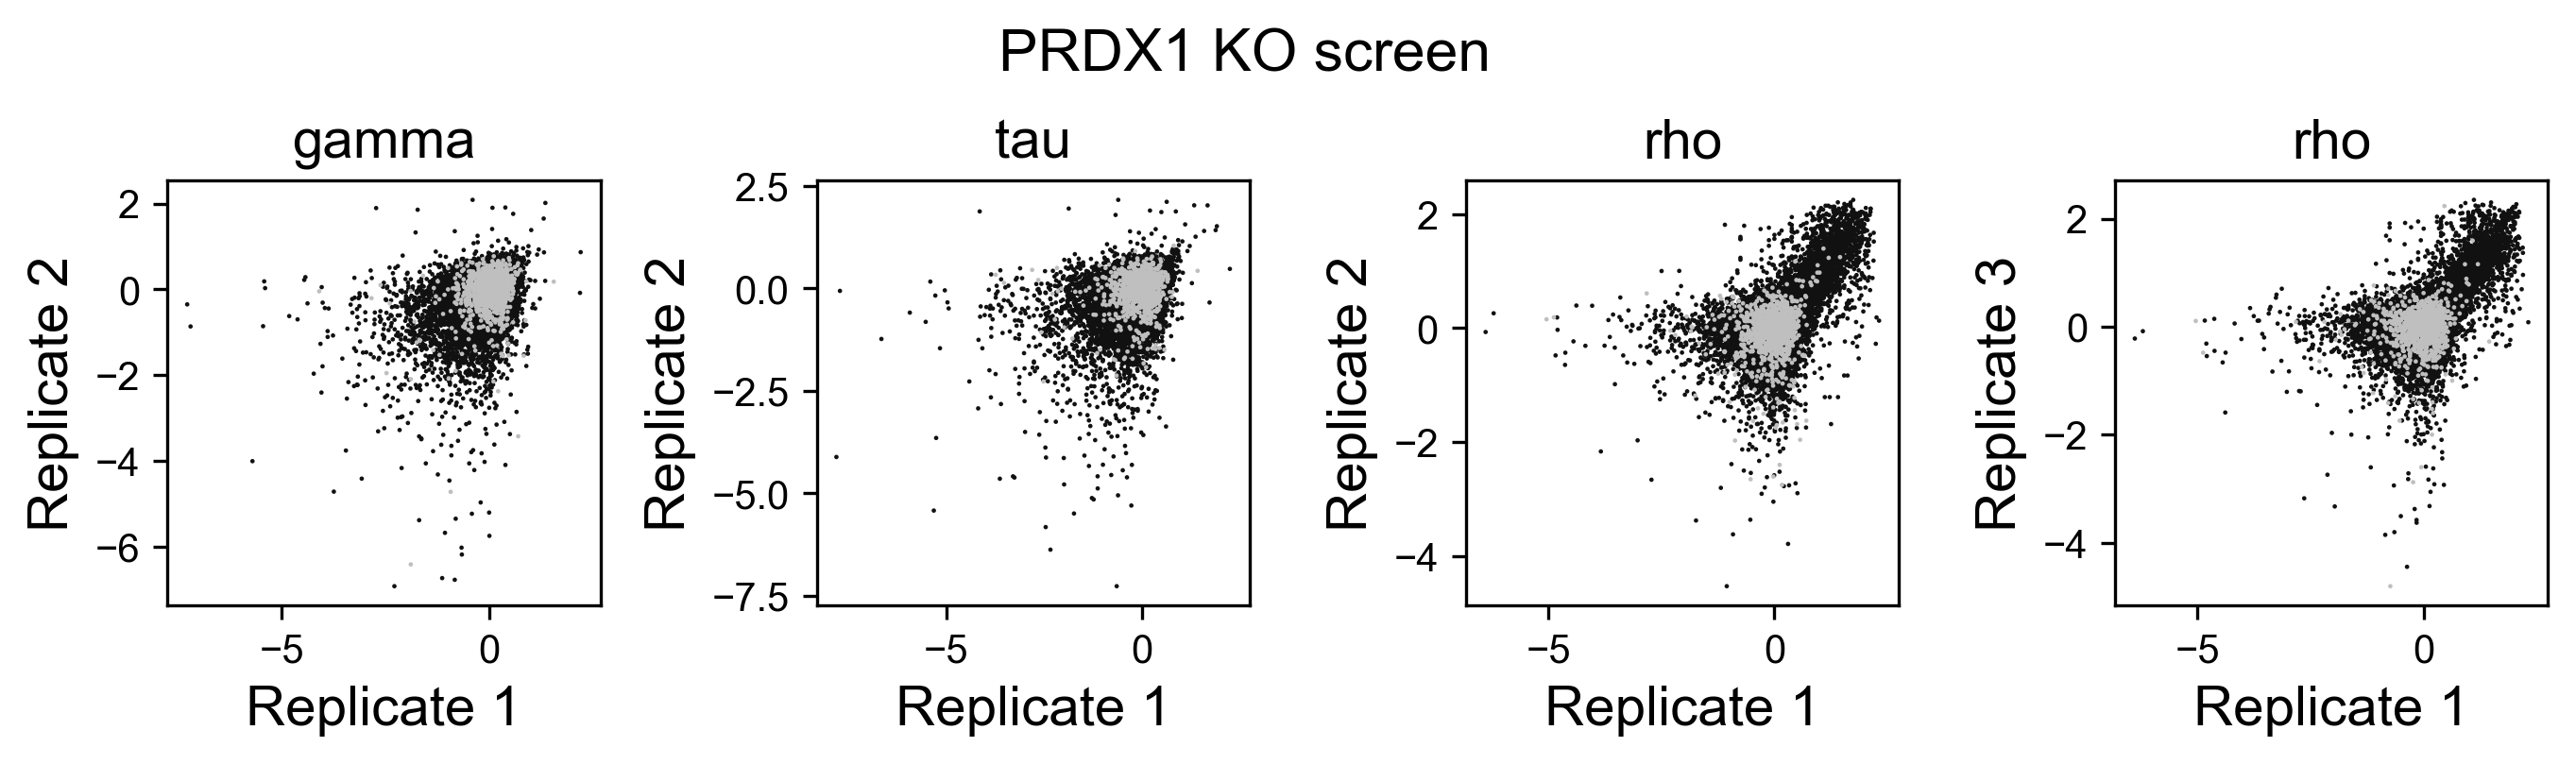

In [132]:
fig, axes = plt.subplots(ncols=4,
                         figsize=(10,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
draw_scatter(pdata, 'gamma_replicate_1','gamma_replicate_2','gamma', axes[0])
draw_scatter(pdata, 'tau_replicate_1','tau_replicate_2','tau', axes[1])

draw_scatter(pdata, 'rho_replicate_1','rho_replicate_2','rho', axes[2])
draw_scatter(pdata, 'rho_replicate_1','rho_replicate_3','rho', axes[3])

fig.suptitle('PRDX1 KO screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

# 

In [114]:
%reload_ext watermark

In [115]:
%watermark

Last updated: 2023-12-14T16:21:15.301945-08:00

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.15.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 10
Architecture: 64bit



In [116]:
%watermark --iversions

scanpy    : 1.9.1
screenpro : 0.2.5
anndata   : 0.8.0
numpy     : 1.26.2
matplotlib: 3.6.2
pandas    : 1.5.3



In [117]:
!date

Thu Dec 14 16:21:16 PST 2023
